#Test Clustering with Diveristy of Image Complexity 

####Import Libraries

In [1]:
import hdbscan
from collections import Counter

In [2]:
from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from time import time
import numpy as np
import pandas as pd
from astropy.convolution import convolve_fft, convolve
import astropy.convolution
import os
%matplotlib inline

In [3]:
import os

In [4]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

####Import User Defined Library

In [5]:
import Cylindrical_Map_Transformation as map_trans

ImportError: No module named Cylindrical_Map_Transformation

In [ ]:
import extract_image_features as extract

In [ ]:
import Centroid_Labeling as cl

In [ ]:
import extract_feautres_script  as extract_script

In [ ]:
def preprocess_image(hdu_object):
    # upload data to dataframe in order to replace nans with zeros
    df = pd.DataFrame(hdu_object.data)
    df.fillna(value=0,
              inplace=True)
    clean_data = df.values
        
    # extract parameters from header  
    xCen,yCen,s0,nx,pixsize,p0,b0, r0 = map_trans.get_header_params_MDI(hdu_object.header)
    
    # transform data into cylindrical equal area map
    return map_trans.map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, clean_data)

####Load Images

In [ ]:
path = "/Users/Alexander/NASA/NASA_Sample_Data/Images/"
filelist = []
for i, filename in enumerate(os.listdir(path)):
    if i != 0:
        filelist.append(filename)

####Get an image index for every day of the month

In [ ]:
i = 0
date_dict = {}
for i in xrange(len(filelist)):
    hdu = fits.open(path + filelist[i])[0]
    date_dict[hdu.header["DATE-OBS"]] = i

In [12]:
date_dict

{'2003/10/01': 4,
 '2003/10/02': 16,
 '2003/10/03': 31,
 '2003/10/04': 39,
 '2003/10/05': 53,
 '2003/10/06': 66,
 '2003/10/07': 81,
 '2003/10/08': 91,
 '2003/10/09': 104,
 '2003/10/10': 120,
 '2003/10/11': 134,
 '2003/10/12': 148,
 '2003/10/13': 164,
 '2003/10/14': 179,
 '2003/10/15': 193,
 '2003/10/16': 207,
 '2003/10/17': 213,
 '2003/10/18': 229,
 '2003/10/19': 244,
 '2003/10/20': 259,
 '2003/10/21': 274,
 '2003/10/22': 289,
 '2003/10/23': 304,
 '2003/10/24': 319,
 '2003/10/25': 334,
 '2003/10/26': 349,
 '2003/10/27': 364,
 '2003/10/28': 373,
 '2003/10/29': 382,
 '2003/10/30': 397,
 '2003/10/31': 412}

In [8]:
hdu = fits.open(path + filelist[412])[0]
image_test = preprocess_image(hdu)

##Test HDBSCAN with complex late-Oct image

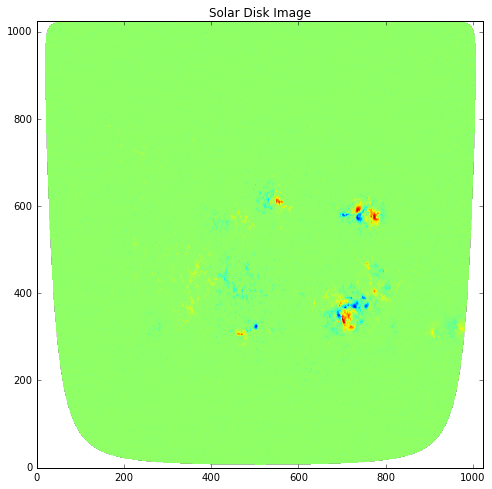

In [9]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(image_test== 0.0,image_test)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
# plt.xlim((650,850))
# plt.ylim((280,460))
# plt.colorbar()

plt.show()

####Load Sample Image

In [32]:
# path = "/Users/Alexander/NASA/NASA_Sample_Data/fd_M_96m_01d.6543.0000.fits"
# hdulist = fits.open(path)
# hdu = hdulist[0]

# # clean image
# df = pd.DataFrame(hdu.data)
# df.fillna(value=0,inplace=True)
# clean_data = df.values

# # get image parameters from header
# xCen_2,yCen_2,s0_2,nx_2,pixsize_2,p0_2,b0_2, r0_2 = map_trans.get_header_params_MDI(hdu.header)

# # transform image into Equal Area Cylindrical Map
# trans_image = map_trans.map_disk_cylindric(xCen_2,yCen_2,s0_2,nx_2,pixsize_2,p0_2,b0_2, r0_2, clean_data)

# Take abs of data to identify active regions, the signs doesn't matter
# data_abs = np.abs(trans_image)

####Convolve Image
    Std parameter for this image has been tuned to 6
    DO NOT take abs value of image data

In [10]:
gauss = astropy.convolution.Gaussian2DKernel(stddev=6)

In [11]:
gauss_data = convolve_fft(image_test, gauss)

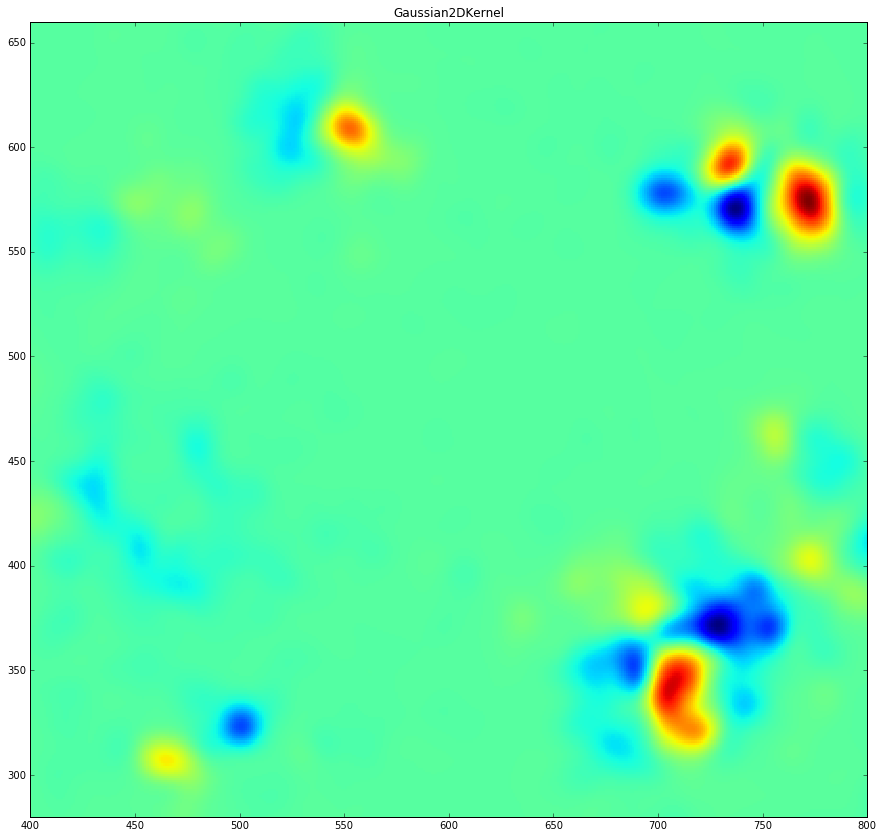

In [21]:
plt.figure(figsize = (15,15));
plt.imshow(gauss_data, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel")
#plt.colorbar()
plt.xlim((400,800))
plt.ylim((280,660))
plt.show()

In [13]:
start = time()
distance = ndi.distance_transform_edt(image_test)
# Find peaks in an image, and return them as coordinates or a boolean array
local_maxi = peak_local_max(distance, 
                            indices=False, 
                            footprint=np.ones((3, 3)),
                            labels=image_test)
# return labels of peaks
markers = ndi.label(local_maxi)[0]
# Return a matrix labeled using the watershed segmentation algorithm
labels = watershed(-distance, markers, mask=image_test)
end = time()
print "Time Elapsed = {:.3}".format(end - start)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (12,12));
plt.imshow(labels,  origin='lower');

####Apply Active Region Map to Image


In [14]:
def get_filtered_image(data):
    mag_flux_thresh = 130
    filtered_image = []
    x_coords = []
    y_coords = []
    for x, row in enumerate(data):
        for y, z in enumerate(row):
            if z >= mag_flux_thresh or z <= -mag_flux_thresh:
                filtered_image.append([x,y,z])
                x_coords.append(x)
                y_coords.append(y)
    return x_coords, y_coords,filtered_image

In [15]:
x_coords, y_coords,filtered_image = get_filtered_image(gauss_data)

###Hierarchical Clustering


In [56]:
# min_cluster_size -- n points in each cluster
# min_samples -- m points that need to sourround a core point to be considered a core point
model = hdbscan.HDBSCAN(min_cluster_size=50, 
                        min_samples=350)

In [57]:
# reread explaination for this plot
#HDBSCAN is very confident about its clusters
#plt.figure(figsize = (12,12));
#model.condensed_tree_.plot( label_clusters=True);

In [58]:
cluster_labels = model.fit_predict(filtered_image)

In [59]:
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [52]:
cluster_sizes = np.arange(50,1000,50)
sample_sizes = np.arange(50,1000,50)

In [42]:
len(cluster_sizes)

19

In [43]:
results = []
start = time()

for cluster_size in cluster_sizes:
    print "cluster size = {}".format(cluster_size)
    for sample_size in sample_sizes:
        model = hdbscan.HDBSCAN(min_cluster_size=int(cluster_size), 
                                min_samples=int(sample_size))
        
        cluster_labels = model.fit_predict(filtered_image)
        
        results.append([cluster_size,sample_size,np.unique(cluster_labels) ])
end = time()

print "Time Elapsed  = {}".format(end - start)

cluster size = 50
cluster size = 100
cluster size = 150
cluster size = 200
cluster size = 250
cluster size = 300
cluster size = 350
cluster size = 400
cluster size = 450
cluster size = 500
cluster size = 550
cluster size = 600
cluster size = 650
cluster size = 700
cluster size = 750
cluster size = 800
cluster size = 850
cluster size = 900
cluster size = 950
Time Elapsed  = 598.015111923


In [47]:
results

[[50,
  50,
  array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18])],
 [50,
  100,
  array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])],
 [50,
  150,
  array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])],
 [50, 200, array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])],
 [50, 250, array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])],
 [50, 300, array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])],
 [50, 350, array([-1,  0,  1,  2,  3,  4,  5])],
 [50, 400, array([-1,  0,  1,  2,  3,  4,  5])],
 [50, 450, array([-1,  0,  1,  2,  3,  4,  5,  6])],
 [50, 500, array([-1,  0,  1,  2,  3,  4,  5,  6])],
 [50, 550, array([-1,  0,  1,  2,  3,  4,  5,  6])],
 [50, 600, array([-1,  0,  1,  2,  3,  4,  5,  6])],
 [50, 650, array([-1,  0,  1,  2,  3,  4,  5])],
 [50, 700, array([-1,  0,  1,  2,  3,  4])],
 [50, 750, array([-1,  0,  1,  2,  3,  4])],
 [50, 800, array([-1,  0,  1,  2,  3,  4])],
 [50, 85

##ToDo
    Get "True" number of active regions from NOAA data
    Get parameters the result in same number of active regions as NOAA
    

####Load NOAA data

In [13]:
# noaa_path = "/Users/Alexander/NASA/MDI_data/rgn{}.txt".format(noaa_year)
noaa_path = "/Users/Alexander/NASA/MDI_data/"
noaa_data = extract.get_noaa_sunspot_files(noaa_path)

In [14]:
# RUN AT NIGHT
resutls = extract_script.extract_features_from_images(path, filelist[412])

get active region map...
save image data to picke file...
identify active regions in image for file


KeyboardInterrupt: 